# Import final data

In [76]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import nltk
import spacy
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics

In [77]:
df = pd.read_csv('./saved_data/second_data.csv')
df.head()

,id,title,body,num_comments,upvotes,time_posted,time_now,time_delta,subreddit,text_length
0,jvq4pp,"PSA: If you hate PETA, that's because a right ...",A huge smear campaign started by \n\nPeta Kill...,901,2829,1.605605e+09,2021-05-16 11:36:28.594755,180 days 02:07:37.594756,vegan,285
1,114zvn,I was a Vegan for several months until this pa...,They said that the goats ate only fresh goat f...,239,0,1.349707e+09,2021-05-16 11:36:28.594762,3141 days 21:06:08.594763,vegan,325
2,lenglo,why are vegan subs so cowardly when it comes t...,~~I’m pretty sure I was just quietly banned~~ ...,75,3,1.612708e+09,2021-05-16 11:36:28.594795,97 days 21:07:42.594795,vegan,299
3,ixiq4p,White Veganism and Why it's Problematic,"Personally, I'm a person of color and it frust...",64,0,1.600759e+09,2021-05-16 11:36:28.594806,236 days 04:18:37.594806,vegan,383
4,giowc5,tired of cigarette smokers calling themselves ...,you literally can’t smoke cigarettes and be a ...,14,1,1.589333e+09,2021-05-16 11:36:28.594824,368 days 10:20:15.594824,vegan,89


In [78]:
# need to rename text_length, is actually body_length
df.rename(columns = {'text_length':'body_length'}, inplace=True)
df.head()

,id,title,body,num_comments,upvotes,time_posted,time_now,time_delta,subreddit,body_length
0,jvq4pp,"PSA: If you hate PETA, that's because a right ...",A huge smear campaign started by \n\nPeta Kill...,901,2829,1.605605e+09,2021-05-16 11:36:28.594755,180 days 02:07:37.594756,vegan,285
1,114zvn,I was a Vegan for several months until this pa...,They said that the goats ate only fresh goat f...,239,0,1.349707e+09,2021-05-16 11:36:28.594762,3141 days 21:06:08.594763,vegan,325
2,lenglo,why are vegan subs so cowardly when it comes t...,~~I’m pretty sure I was just quietly banned~~ ...,75,3,1.612708e+09,2021-05-16 11:36:28.594795,97 days 21:07:42.594795,vegan,299
3,ixiq4p,White Veganism and Why it's Problematic,"Personally, I'm a person of color and it frust...",64,0,1.600759e+09,2021-05-16 11:36:28.594806,236 days 04:18:37.594806,vegan,383
4,giowc5,tired of cigarette smokers calling themselves ...,you literally can’t smoke cigarettes and be a ...,14,1,1.589333e+09,2021-05-16 11:36:28.594824,368 days 10:20:15.594824,vegan,89


In [79]:
# check for nulls
df.isnull().sum()

id              0
title           0
body            0
num_comments    0
upvotes         0
time_posted     0
time_now        0
time_delta      0
subreddit       0
body_length     0
dtype: int64

# Remove Outliers

<AxesSubplot:xlabel='body_length'>

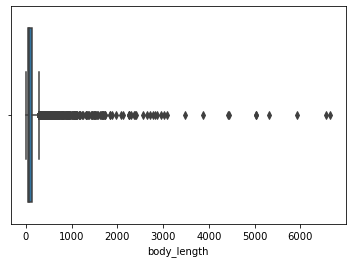

In [80]:
# From the work in the notebook labeled Initial_Preprocess_EDA, distribution of post length/body length
# is likely a problem and a boxplot is useful
sns.boxplot(x=df['body_length'])

In [81]:
# remove rows with body length greater than 1000
df = df[df['body_length'] < 1000]

<AxesSubplot:xlabel='body_length'>

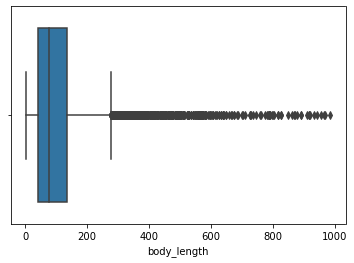

In [82]:
sns.boxplot(x=df['body_length'])

In [83]:
# remove rows with body length greater than 600
df = df[df['body_length'] < 600]

<AxesSubplot:xlabel='body_length'>

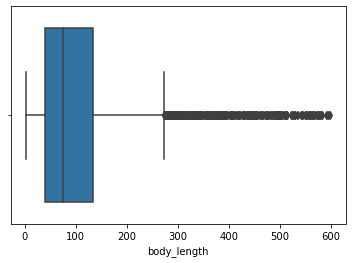

In [84]:
sns.boxplot(x=df['body_length'])

# Show distributions

In [85]:
df_vegan = df[df['subreddit'] == 'vegan']
df_vegan['body_length'].describe()

count    2266.000000
mean      123.545896
std       114.786966
min         2.000000
25%        44.000000
50%        87.000000
75%       162.000000
max       599.000000
Name: body_length, dtype: float64

In [86]:
df_Cooking = df[df['subreddit'] == 'Cooking']
df_Cooking['body_length'].describe()

count    5255.000000
mean       98.378687
std        92.831400
min         2.000000
25%        40.000000
50%        70.000000
75%       122.000000
max       592.000000
Name: body_length, dtype: float64

In [87]:
df_Cooking

,id,title,body,num_comments,upvotes,time_posted,time_now,time_delta,subreddit,body_length
1669,2pd34q,Confession....I dislike crock pots!,I know i may get downvotes and accused of bein...,223,20,1.418656e+09,2021-05-16 12:14:20.267206,2343 days 21:15:12.267207,Cooking,261
1670,luhfdv,Why the FUCK would anyone buy an induction stove?,I can't express my hatred for these fucking th...,89,1,1.614523e+09,2021-05-16 12:14:20.267211,76 days 21:41:20.267212,Cooking,73
1671,5s8944,"Life Pro Tips: If you buy a pack of salad, don...","I'd rather have un-fresh, dried out, edible l...",112,377,1.486312e+09,2021-05-16 12:14:20.267215,1560 days 19:47:43.267216,Cooking,14
1672,lwgoa2,Earlier comment....,I made a comment earlier today that was insens...,69,23,1.614731e+09,2021-05-16 12:14:20.267219,74 days 11:48:31.267220,Cooking,126
1673,38semd,TIL putting mayo on fish,[prevents it from sticking to the grill.](http...,16,2,1.433592e+09,2021-05-16 12:14:20.267227,2171 days 00:06:35.267227,Cooking,7
...,...,...,...,...,...,...,...,...,...,...
7661,n7w0rc,MB's Favourite & Simple Coleslaw,"""Eat your veggies"" They say... Well, here I a...",1,0,1.620500e+09,2021-05-19 02:03:07.406931,10 days 07:01:46.406932,Cooking,126
7662,n7vu04,Trying to make a pizza before my sister comes ...,Im about to make a pizza for mary and possible...,10,0,1.620500e+09,2021-05-19 02:03:07.406937,10 days 07:10:57.406937,Cooking,313
7663,n7vrdl,What's something you used to do from scratch b...,"For me, pesto. Fresh pesto is awesome but larg...",223,209,1.620500e+09,2021-05-19 02:03:07.406944,10 days 07:14:33.406945,Cooking,65
7664,n7vr82,Your best pizza dough for bbq with pizza stone...,"Hi all,\n\n&#x200B;\n\nI have a gas bbq and a ...",8,1,1.620500e+09,2021-05-19 02:03:07.406949,10 days 07:14:45.406950,Cooking,48


**Analysis**: In the Initial_Preprocess_EDA notebook, there were major differences in mean and standard deviation between the data in the two subreddits. Removing outliers made the means, standard deviations, and medians reasonably similar

# Clean Data

In [88]:
# check the shape before cleaning
df.shape

(7521, 10)

In [89]:
# Text cleaning function from 
# https://medium.com/analytics-vidhya/text-cleaning-in-natural-language-processing-nlp-bea2c27035a6
def clean_text(col_w_text):
    # replace html characters with space
    col_w_text= [re.sub('<.*?>', ' ', t) for t in col_w_text]  
    #remove punctuation
    col_w_text = [t.translate(str.maketrans(' ',' ',string.punctuation)) for t in col_w_text]
    # keep only letters and numbers
    col_w_text = [re.sub('[^a-zA-Z]',' ',t) for t in col_w_text] 
    # replace newline with space
    col_w_text = [re.sub("\n"," ",t) for t in col_w_text]
    # convert to lowercase
    col_w_text = [t.lower() for t in col_w_text]
    # split and join the words
    col_w_text = [' '.join(t.split()) for t in col_w_text]
    
    return col_w_text

In [90]:
# clean the title column
df['title'] = clean_text(df['title'])

In [91]:
# clean the body column
df['body'] = clean_text(df['body'])

In [92]:
# update the length of the body text. The length is 1 for an empty column.
df['body_length'] = [len(x.split(' ')) for x in df.body]

In [93]:
# Remove any empty body columns created during cleaning
df = df[df.body_length != 1]
df.head()

,id,title,body,num_comments,upvotes,time_posted,time_now,time_delta,subreddit,body_length
0,jvq4pp,psa if you hate peta thats because a right win...,a huge smear campaign started by peta kills an...,901,2829,1.605605e+09,2021-05-16 11:36:28.594755,180 days 02:07:37.594756,vegan,280
1,114zvn,i was a vegan for several months until this pa...,they said that the goats ate only fresh goat f...,239,0,1.349707e+09,2021-05-16 11:36:28.594762,3141 days 21:06:08.594763,vegan,300
2,lenglo,why are vegan subs so cowardly when it comes t...,i m pretty sure i was just quietly banned edit...,75,3,1.612708e+09,2021-05-16 11:36:28.594795,97 days 21:07:42.594795,vegan,321
3,ixiq4p,white veganism and why its problematic,personally im a person of color and it frustra...,64,0,1.600759e+09,2021-05-16 11:36:28.594806,236 days 04:18:37.594806,vegan,382
4,giowc5,tired of cigarette smokers calling themselves ...,you literally can t smoke cigarettes and be a ...,14,1,1.589333e+09,2021-05-16 11:36:28.594824,368 days 10:20:15.594824,vegan,93


In [94]:
# only removed two rows
df.shape

(7519, 10)

In [95]:
# get the length of the title text
df['title_length'] = [len(x.split(' ')) for x in df.title]

In [96]:
# Remove any empty title columns
df = df[df.title_length != 1]
df.head()

,id,title,body,num_comments,upvotes,time_posted,time_now,time_delta,subreddit,body_length,title_length
0,jvq4pp,psa if you hate peta thats because a right win...,a huge smear campaign started by peta kills an...,901,2829,1.605605e+09,2021-05-16 11:36:28.594755,180 days 02:07:37.594756,vegan,280,16
1,114zvn,i was a vegan for several months until this pa...,they said that the goats ate only fresh goat f...,239,0,1.349707e+09,2021-05-16 11:36:28.594762,3141 days 21:06:08.594763,vegan,300,38
2,lenglo,why are vegan subs so cowardly when it comes t...,i m pretty sure i was just quietly banned edit...,75,3,1.612708e+09,2021-05-16 11:36:28.594795,97 days 21:07:42.594795,vegan,321,13
3,ixiq4p,white veganism and why its problematic,personally im a person of color and it frustra...,64,0,1.600759e+09,2021-05-16 11:36:28.594806,236 days 04:18:37.594806,vegan,382,6
4,giowc5,tired of cigarette smokers calling themselves ...,you literally can t smoke cigarettes and be a ...,14,1,1.589333e+09,2021-05-16 11:36:28.594824,368 days 10:20:15.594824,vegan,93,7


In [97]:
# removed 83 rows
df.shape

(7436, 11)

In [98]:
# Check the distribution between subreddits
df['subreddit'].value_counts()

Cooking    5210
vegan      2226
Name: subreddit, dtype: int64

# Based on the work done in the second notebook, Lemmatize

In [99]:
lemmatizer = WordNetLemmatizer()
tokenizer = WhitespaceTokenizer()

In [100]:
# Function to lemmatize text
# Referred to https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells
# Need to tokenize to create words, then lemmatize
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)])

In [101]:
# Lemmatize the title column
df['lemmatized_title'] = df['title'].apply(lemmatize_text)

In [102]:
# Lemmatize the body column
df['lemmatized_body'] = df['body'].apply(lemmatize_text)

In [103]:
# binarize the target variable. 
# Vegan is the class with the idealistic consumers, so I will make it the positive class.
df['subreddit'] = df['subreddit'].map({'vegan': 1, 'Cooking': 0})

# Try a random forest model on the title

In [104]:
# Model the lemmatized title
X = df['lemmatized_title']
y = df['subreddit']

#### Obtain baseline accuracy - 0.70

In [105]:
y.value_counts(normalize=True).values[0]

0.700645508337816

In [106]:
# stratify the samples because the are imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [107]:
# Create a pipeline for random forest modeling
pipe_rand_forest = Pipeline([
    ('vect', TfidfVectorizer(stop_words = 'english')),
    ('model', RandomForestClassifier(max_depth=4, class_weight='balanced', n_jobs = -1)),
])

In [108]:
grid = {
    'vect__max_df': [.7, .8, .9],
    'vect__max_features': [200, 1000]
}
model_1 = GridSearchCV(pipe_rand_forest, param_grid=grid)
model_1.fit(X_train, y_train)
print(model_1.best_score_) # <- a cross val score
model_1.best_params_

0.8725107285790058


{'vect__max_df': 0.9, 'vect__max_features': 1000}

In [109]:
# model score for test data
model_1.score(X_test, y_test)

0.8612157073695536

In [110]:
# model score for training data
model_1.score(X_train, y_train)

0.8913394298009683

**CONCLUSION**: the cross val score from GridSearchCV, the test score, and the train score are very close to each other. The scores are higher than the baseline of 0.70. Models with scores above 0.85 are okay. So this is a decent model.

# Try a Logistic Regression Model on the same data as above

In [111]:
pipe_log_r = Pipeline([
    ('vect', TfidfVectorizer(stop_words = 'english')),
    ('model', LogisticRegression())
])

In [112]:
# Use the data and parameters from above
model_2 = GridSearchCV(pipe_log_r, param_grid=grid)
model_2.fit(X_train, y_train)
print(model_2.best_score_) # <- a cross val score
model_2.best_params_

0.8929525692334893


{'vect__max_df': 0.7, 'vect__max_features': 1000}

In [113]:
# model score for test data
model_2.score(X_test, y_test)

0.8811188811188811

In [114]:
# model score for training data
model_2.score(X_train, y_train)

0.9168011475703783

**Conclusion**: train score is a little bigger than test score. May be overfit. Also, feature importances are easier to interpret in random forest models than coefficients in logistic regression models. I will use random forest models.

## For Tf-IDF vectorized data, create random forest models on lemmatized title and body text

### Grid and pipe for the random forest models with the Tfidf Vectorizer

In [115]:
# Create a pipeline for random forest modeling for both the title and body text
# Use class_weight of balanced because these are imbalanced classes
pipe_rforest_Tfidf = Pipeline([
    ('vect', TfidfVectorizer(stop_words = 'english')),
    ('model', RandomForestClassifier(class_weight='balanced', n_jobs = -1))
])


In [116]:
# run the model on the X and y that were created above, from the lemmatized title
# use this tuning for the rest of the models
grid = {
    'vect__max_df': [.75, .8, .85],
    'vect__max_features': [1000, 3000, 5000],
    'model__max_depth': [5, 10, 15]
}

model_3 = GridSearchCV(pipe_rforest_Tfidf, param_grid=grid)
model_3.fit(X_train, y_train)
print(model_3.best_score_) # <- a cross val score
model_3.best_params_

0.8900837391709662


{'model__max_depth': 15, 'vect__max_df': 0.85, 'vect__max_features': 3000}

In [117]:
model_3.score(X_train, y_train)

0.9108839878070647

In [118]:
model_3.score(X_test, y_test)

0.8768154922001076

**CONCLUSION FOR LEMMATIZED TITLE**: the cross val score from GridSearchCV, the test score, and the train score are very close to each other. The scores are higher than the baseline of 0.70. Models with scores above 0.85 are okay. So this is a decent model.

#### Model for lemmatized body text

In [119]:
# Model the lemmatized body
X1 = df['lemmatized_body']
y1 = df['subreddit']

In [120]:
# stratify the samples because the are imbalanced
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=42, stratify=y)

In [121]:
model_4 = GridSearchCV(pipe_rforest_Tfidf, param_grid=grid)
model_4.fit(X1_train, y1_train)
print(model_4.best_score_) # <- a cross val score
model_4.best_params_

0.9393932526479901


{'model__max_depth': 15, 'vect__max_df': 0.75, 'vect__max_features': 3000}

In [122]:
model_4.score(X1_train, y1_train)

0.9616281154742693

In [123]:
model_4.score(X1_test, y1_test)

0.9381387842926304

**CONCLUSION FOR LEMMATIZED BODY**: the cross val score from GridSearchCV, the test score, and the train score are very close to each other. The scores are higher than the baseline of 0.70. This is a very high score. So this is a good model, as expected because the body text has more data.

In [124]:
preds = model_4.predict(X1_test)

#### Model evaluation for lemmatized body text

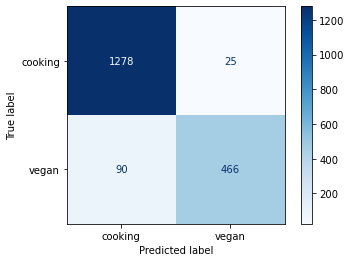

In [125]:
# https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/20_plot_confusion_matrix.ipynb

metrics.plot_confusion_matrix(model_4, X1_test, y1_test, cmap='Blues', 
                      values_format='d', display_labels=['cooking', 'vegan']);

In [126]:
metrics.accuracy_score(y1_test, preds)

0.9381387842926304

In [127]:
metrics.recall_score(y1_test, preds)

0.8381294964028777

In [128]:
metrics.precision_score(y1_test, preds)

0.9490835030549898

**Conclusions**: The accuracy of the model is very good. The percent of correct positive predictions, as measured by the precision score, is particularly good, reflecting that the model predicts posts that belong in the vegan subreddit particularly well. It overfits the vegan subreddit, likely.

### In order to get feature importances, run the model again with the best parameters

In [129]:
# Instantiate best model above
tvec = TfidfVectorizer(stop_words = 'english',
                       max_features = 3000,
                       max_df = .85
)

In [130]:
# fit on data used above
tvec.fit(X1_train)

TfidfVectorizer(max_df=0.85, max_features=3000, stop_words='english')

In [131]:
# get vectorized data and add target column
df_tvec = pd.DataFrame(tvec.transform(X1_train).todense(),
                  columns = tvec.get_feature_names())

In [132]:
# run random forest model
rf = RandomForestClassifier(class_weight='balanced', 
                            max_depth = 15,
                            n_jobs = -1)

In [133]:
rf.fit(df_tvec, y1_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_jobs=-1)

In [134]:
feat_table = pd.Series(rf.feature_importances_, index=df_tvec.columns)

In [135]:
feat_table.sort_values(ascending=False).head(15)

vegan       0.183052
animal      0.049452
recipe      0.032499
cooking     0.031945
veganism    0.029530
cook        0.028441
diet        0.018488
people      0.017623
eating      0.017421
product     0.017024
sauce       0.013535
salt        0.012779
meat        0.011026
cooked      0.009999
pan         0.009853
dtype: float64

**Conclusion**: The main story from these feature importances is that "animal" and "recipe" are important distinguishing words. It seems like the vegan subreddit talks about animal rights in the abstract and that the cooking subreddit contains recipes, while the vegan subreddit does not contain nearly as high of a proportion of recipes.

## Get top words in lemmatized body for each subreddit

### The current dataframe contains a lemmatized body column. Create new dataframes for each subreddit to count lemmatized body words in each subreddit

In [136]:
df.head()

,id,title,body,num_comments,upvotes,time_posted,time_now,time_delta,subreddit,body_length,title_length,lemmatized_title,lemmatized_body
0,jvq4pp,psa if you hate peta thats because a right win...,a huge smear campaign started by peta kills an...,901,2829,1.605605e+09,2021-05-16 11:36:28.594755,180 days 02:07:37.594756,1,280,16,psa if you hate peta thats because a right win...,a huge smear campaign started by peta kill ani...
1,114zvn,i was a vegan for several months until this pa...,they said that the goats ate only fresh goat f...,239,0,1.349707e+09,2021-05-16 11:36:28.594762,3141 days 21:06:08.594763,1,300,38,i wa a vegan for several month until this past...,they said that the goat ate only fresh goat fe...
2,lenglo,why are vegan subs so cowardly when it comes t...,i m pretty sure i was just quietly banned edit...,75,3,1.612708e+09,2021-05-16 11:36:28.594795,97 days 21:07:42.594795,1,321,13,why are vegan sub so cowardly when it come to ...,i m pretty sure i wa just quietly banned edit ...
3,ixiq4p,white veganism and why its problematic,personally im a person of color and it frustra...,64,0,1.600759e+09,2021-05-16 11:36:28.594806,236 days 04:18:37.594806,1,382,6,white veganism and why it problematic,personally im a person of color and it frustra...
4,giowc5,tired of cigarette smokers calling themselves ...,you literally can t smoke cigarettes and be a ...,14,1,1.589333e+09,2021-05-16 11:36:28.594824,368 days 10:20:15.594824,1,93,7,tired of cigarette smoker calling themselves v...,you literally can t smoke cigarette and be a v...


In [137]:
# vegan subreddit was binarized to 1
df_vegan_gr = df[df['subreddit'] == 1]
df_vegan_gr.head()

,id,title,body,num_comments,upvotes,time_posted,time_now,time_delta,subreddit,body_length,title_length,lemmatized_title,lemmatized_body
0,jvq4pp,psa if you hate peta thats because a right win...,a huge smear campaign started by peta kills an...,901,2829,1.605605e+09,2021-05-16 11:36:28.594755,180 days 02:07:37.594756,1,280,16,psa if you hate peta thats because a right win...,a huge smear campaign started by peta kill ani...
1,114zvn,i was a vegan for several months until this pa...,they said that the goats ate only fresh goat f...,239,0,1.349707e+09,2021-05-16 11:36:28.594762,3141 days 21:06:08.594763,1,300,38,i wa a vegan for several month until this past...,they said that the goat ate only fresh goat fe...
2,lenglo,why are vegan subs so cowardly when it comes t...,i m pretty sure i was just quietly banned edit...,75,3,1.612708e+09,2021-05-16 11:36:28.594795,97 days 21:07:42.594795,1,321,13,why are vegan sub so cowardly when it come to ...,i m pretty sure i wa just quietly banned edit ...
3,ixiq4p,white veganism and why its problematic,personally im a person of color and it frustra...,64,0,1.600759e+09,2021-05-16 11:36:28.594806,236 days 04:18:37.594806,1,382,6,white veganism and why it problematic,personally im a person of color and it frustra...
4,giowc5,tired of cigarette smokers calling themselves ...,you literally can t smoke cigarettes and be a ...,14,1,1.589333e+09,2021-05-16 11:36:28.594824,368 days 10:20:15.594824,1,93,7,tired of cigarette smoker calling themselves v...,you literally can t smoke cigarette and be a v...


In [138]:
# cooking subreddit was binarized to 0
df_cooking_gr = df[df['subreddit'] == 0]
df_cooking_gr.head()

,id,title,body,num_comments,upvotes,time_posted,time_now,time_delta,subreddit,body_length,title_length,lemmatized_title,lemmatized_body
1669,2pd34q,confessioni dislike crock pots,i know i may get downvotes and accused of bein...,223,20,1.418656e+09,2021-05-16 12:14:20.267206,2343 days 21:15:12.267207,0,246,4,confessioni dislike crock pot,i know i may get downvotes and accused of bein...
1670,luhfdv,why the fuck would anyone buy an induction stove,i cant express my hatred for these fucking thi...,89,1,1.614523e+09,2021-05-16 12:14:20.267211,76 days 21:41:20.267212,0,73,9,why the fuck would anyone buy an induction stove,i cant express my hatred for these fucking thi...
1671,5s8944,life pro tips if you buy a pack of salad dont ...,id rather have unfresh dried out edible leafs ...,112,377,1.486312e+09,2021-05-16 12:14:20.267215,1560 days 19:47:43.267216,0,12,50,life pro tip if you buy a pack of salad dont l...,id rather have unfresh dried out edible leaf t...
1672,lwgoa2,earlier comment,i made a comment earlier today that was insens...,69,23,1.614731e+09,2021-05-16 12:14:20.267219,74 days 11:48:31.267220,0,124,2,earlier comment,i made a comment earlier today that wa insensi...
1673,38semd,til putting mayo on fish,prevents it from sticking to the grillhttpwwwt...,16,2,1.433592e+09,2021-05-16 12:14:20.267227,2171 days 00:06:35.267227,0,8,5,til putting mayo on fish,prevents it from sticking to the grillhttpwwwt...


### Get top words in the cooking subreddit body

In [139]:
# Initialize and fit count vectorizer. Remove stop words but leave
# foreign words for possible cooking terminology.
cvec_cooking = CountVectorizer(stop_words = 'english')
cvec_cooking.fit(df_cooking_gr['lemmatized_body'])

CountVectorizer(stop_words='english')

In [140]:
# Put in a dataframe
df_cv_cooking = pd.DataFrame(cvec_cooking.transform(df_cooking_gr['lemmatized_body']).todense(),             
                  columns = cvec_cooking.get_feature_names())
df_cv_cooking.head(10)

,aa,aaa,aaaaaand,aaaaah,aaabag,aaabaghttpswwwyoutubecomwatchv,aaabaghttpswwwyoutubecomwatchvddqvam,aaajm,aah,aai,...,zuccini,zuxrthwkxkqbwsrcqqkfzxusqbuqq,zvkukxcwcumzokl,zw,zwhttpswwwyoutubecomwatchvtuhc,zwilling,zwillinghttpswwwbedbathandbeyondcomstoreproductzwillingjahenckelsenergyplusnonstickstainlesssteel,zwillings,zxrk,zyb
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
# referred to https://stackoverflow.com/questions/60758625/sort-pandas-dataframe-by-sum-of-columns
top_cooking = df_cv_cooking.sum().nlargest(15)

In [142]:
top_cooking

wa         2829
like       2583
just       2560
im         2284
make       2259
recipe     2253
cooking    1784
cook       1670
food       1555
time       1408
know       1321
good       1289
sauce      1252
use        1252
chicken    1158
dtype: int64

<AxesSubplot:>

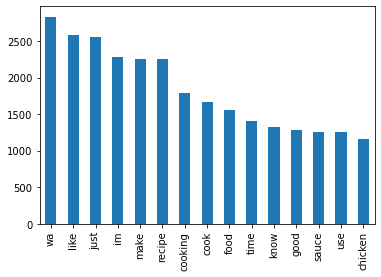

In [143]:
top_cooking.plot(kind='bar')

### Get top words in the vegan subreddit body

In [144]:
# Initialize and fit count vectorizer. Remove stop words but leave
# foreign words for possible cooking terminology.
cvec_vegan = CountVectorizer(stop_words = 'english')
cvec_vegan.fit(df_vegan_gr['lemmatized_body'])

CountVectorizer(stop_words='english')

In [145]:
# put in a dataframe
df_cv_vegan = pd.DataFrame(cvec_vegan.transform(df_vegan_gr['lemmatized_body']).todense(),             
                  columns = cvec_vegan.get_feature_names())

In [146]:
# referred to https://stackoverflow.com/questions/60758625/sort-pandas-dataframe-by-sum-of-columns
top_vegan = df_cv_vegan.sum().nlargest(15)

In [147]:
top_vegan

vegan     3642
animal    1998
just      1434
like      1344
wa        1298
people    1227
meat      1155
im        1089
eat        889
know       862
dont       795
food       771
think      672
make       659
want       658
dtype: int64

<AxesSubplot:>

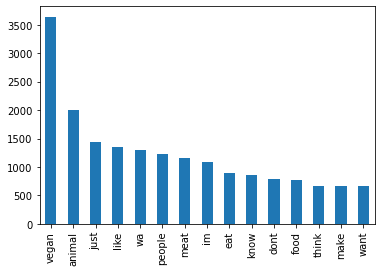

In [148]:
top_vegan.plot(kind='bar')

# Conclusions
- Two of the top words that could distinguish the classes were "animal" and "recipe"
- In r/Cooking, the most common words included "recipe", "sauce", and "chicken"
- In r/vegan, the most common words included "animal", "people", and "think"
- r/vegan is focused on conversation about animal rights and values, and that r/Cooking is focused on conversation about recipes.